In [2]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt

subfolder = "../data/01-01-23_to_01-07-23/"

# Load the CSV file into a DataFrame
cons = pd.read_csv(f'{subfolder}consumption_data.csv', sep=',')
prod = pd.read_csv(f'{subfolder}production_data.csv', sep=',')
price_data_dk2 = pd.read_csv(f'{subfolder}price_data.csv', sep=',')

# Remove entries with MunicipalityNo above 400
cons = cons[cons['MunicipalityNo'] <= 400]

# Display the first few rows of the DataFrame
cons.head(5)
#prod.head(5)

,HourUTC,HourDK,MunicipalityNo,HousingCategory,HeatingCategory,ConsumptionkWh
0,2022-12-31T23:00:00,2023-01-01T00:00:00,101,Andet,Andet,303.528
1,2022-12-31T23:00:00,2023-01-01T00:00:00,147,Andet,Andet,47.490
2,2022-12-31T23:00:00,2023-01-01T00:00:00,151,Andet,Andet,33.770
3,2022-12-31T23:00:00,2023-01-01T00:00:00,153,Andet,Andet,13.410
4,2022-12-31T23:00:00,2023-01-01T00:00:00,155,Andet,Andet,28.120


In [3]:
# Group the dataframe by 'HourDK' and sum the 'ConsumptionkWh' for each group
cons_grouped = cons.groupby('HourDK')['ConsumptionkWh'].sum()

# Divide the 'ConsumptionkWh' by 1000 for cons_grouped to convert to MWh
cons_grouped = cons_grouped / 1000

# Display the updated grouped dataframe
cons_grouped.head()

HourDK
2023-01-01T00:00:00    1239.144140
2023-01-01T01:00:00    1242.394536
2023-01-01T02:00:00    1207.442910
2023-01-01T03:00:00    1180.262035
2023-01-01T04:00:00    1131.530130
Name: ConsumptionkWh, dtype: float64

Here we see how well the Consumption in the Production settlement data match with the consumption computed from the consumption data in DK2.

Minimum difference: -552.2989929999999
Maximum difference: 719.3322219999999


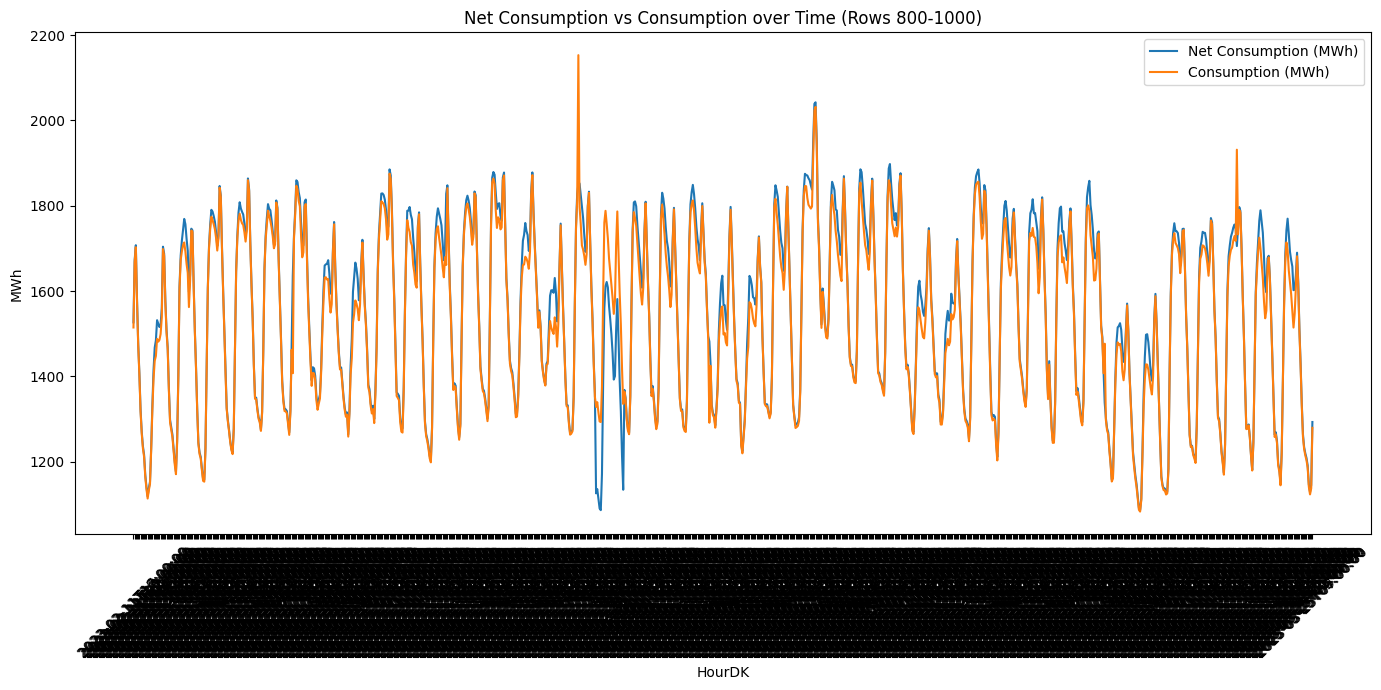

In [4]:
# Calculate 'NetConsumption' and add it as a new column to the dataframe 'prod'
prod['NetConsumption'] = prod['GrossConsumptionMWh'] - prod['GridLossTransmissionMWh'] - prod['GridLossDistributionMWh']
#prod['NetConsumption'] = prod['NetConsumption'] - prod['SolarPowerSelfConMWh'] - prod['LocalPowerSelfConMWh']
prod['TotalLoss'] = prod['GridLossTransmissionMWh'] + prod['GridLossDistributionMWh']
prod['Percentage'] = prod['TotalLoss'] / prod['GrossConsumptionMWh'].astype(float) * 100

prod_netconsumption = prod[['HourDK', 'NetConsumption']]

# Merge the 'cons_grouped' series with 'prod_netconsumption' dataframe on 'HourDK'
prod_netconsumption = prod_netconsumption.merge(cons_grouped, on='HourDK', how='left')

# Rename the 'ConsumptionkWh' column to avoid confusion
prod_netconsumption.rename(columns={'ConsumptionkWh': 'ConsumptionkWh'}, inplace=True)

prod_netconsumption['Diff'] = prod_netconsumption['NetConsumption'] - prod_netconsumption['ConsumptionkWh']


# Checking for outliers and stuff, not finished
# IF doing correction, consumption data should probably be corrected according to the production dataset, as this dataset is more reliable.

print("Minimum difference:", prod_netconsumption['Diff'].min())
print("Maximum difference:", prod_netconsumption['Diff'].max())
# Display the first few rows of the updated dataframe
prod_netconsumption.head()
# Display rows around row number 912
#prod_netconsumption.iloc[3270:3280]

prod_netconsumption_sorted = prod_netconsumption.sort_values(by='Diff', ascending=False)
prod_netconsumption_sorted.head(50)

prod_netconsumption.iloc[3270:3280]

plt.figure(figsize=(14, 7))
plt.plot(prod_netconsumption['HourDK'][1000:2000], prod_netconsumption['NetConsumption'][1000:2000], label='Net Consumption (MWh)')
plt.plot(prod_netconsumption['HourDK'][1000:2000], prod_netconsumption['ConsumptionkWh'][1000:2000], label='Consumption (MWh)')
plt.xlabel('HourDK')
plt.ylabel('MWh')
plt.title('Net Consumption vs Consumption over Time (Rows 800-1000)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we check our dataset for some of the initiable parameters we will use for the model:


In [5]:
print("Min price encountered in dataset:", price_data_dk2['SpotPriceEUR'].min(), "EUR")
print("Max price encountered in dataset:", price_data_dk2['SpotPriceEUR'].max(), "EUR")

Min price encountered in dataset: -10.06 EUR
Max price encountered in dataset: 270.220001 EUR


In [6]:
# Calculate the difference between consecutive rows in the 'CentralPowerMWh' column
prod['CentralPowerMWh_diff'] = prod['CentralPowerMWh'].diff()

# Find the maximum difference
max_diff_id = prod['CentralPowerMWh_diff'].idxmax()
max_diff = prod['CentralPowerMWh_diff'].max()

# Display the row with the maximum difference
prod.iloc[max_diff_id-5:max_diff_id+5]

print("Ramp rate i.e.:")
print("Maximum difference between two adjacent rows in 'CentralPowerMWh':", max_diff)

Ramp rate i.e.:
Maximum difference between two adjacent rows in 'CentralPowerMWh': 231.66278700000004


In [7]:
print('Minimum production of CentralPower plant:', prod['CentralPowerMWh'].min())
print('Maximum production of CentralPower plant:', prod['CentralPowerMWh'].max())



min_prod_id = prod['CentralPowerMWh'].idxmin()


Minimum production of CentralPower plant: 0.0
Maximum production of CentralPower plant: 747.382786


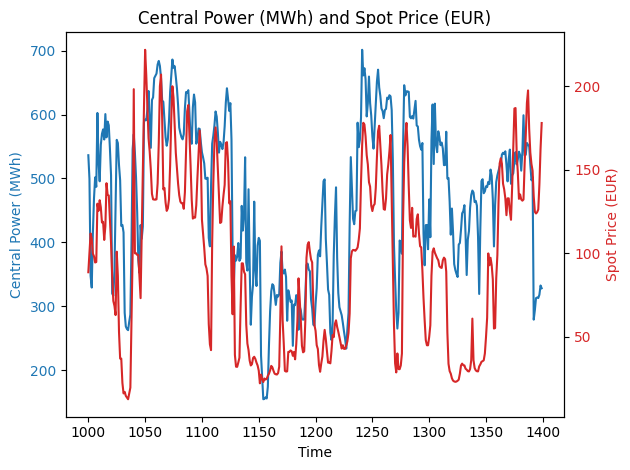

In [10]:
fig, ax1 = plt.subplots()

# Plot CentralPowerMWh from 'prod' on the primary y-axis
ax1.plot(prod['CentralPowerMWh'][1000:1400], color='tab:blue', label='Central Power (MWh)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Central Power (MWh)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis to plot SpotPriceEUR from 'price_data_dk2'
ax2 = ax1.twinx()
ax2.plot(price_data_dk2['SpotPriceEUR'][1000:1400], color='tab:red', label='Spot Price (EUR)')
ax2.set_ylabel('Spot Price (EUR)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Central Power (MWh) and Spot Price (EUR)')
fig.tight_layout()

# Display the plot
plt.show()